# 분류
## MNIST

In [65]:
# MNIST 데이터셋을 내려받는 코드
from sklearn.datasets import fetch_openml
mnist=fetch_openml('mnist_784',version=1)
mnist.keys()

dict_keys(['data', 'target', 'frame', 'categories', 'feature_names', 'target_names', 'DESCR', 'details', 'url'])

In [66]:
X,y=mnist['data'],mnist['target']
X.shape

(70000, 784)

In [67]:
y.shape

(70000,)

In [68]:
X.shape

(70000, 784)

In [69]:
X=X.to_numpy()

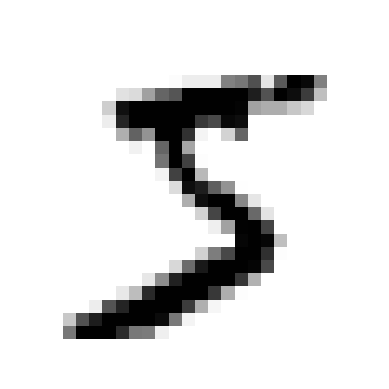

In [70]:
import matplotlib as mpl
import matplotlib.pyplot as plt
some_digit=X[0]
some_digit_image=some_digit.reshape(28,28)
plt.imshow(some_digit_image,cmap='binary')
plt.axis('off')
plt.show()

In [71]:
y[0]

'5'

In [72]:
import numpy as np
y=y.astype(np.uint8)

In [73]:
X_train,X_test,y_train,y_test=X[:60000],X[60000:],y[:60000],y[60000:]

## 3.2 이진분류기 훈련
### : 5와 5가 아님. 두개의 클래스 구분

In [74]:
y_train_5=(y_train==5)
y_test_5=(y_test==5)

In [75]:
# 사이킷런의 SGDClassifier 로 확률적 경사 하강법 분류기로 시작
from sklearn.linear_model import SGDClassifier
sgd_clf=SGDClassifier(random_state=42)
sgd_clf.fit(X_train,y_train_5)
sgd_clf.predict([some_digit])

array([ True])

In [76]:
## 3.3 성능 측정
### 3.3.1 교차 검증을 위한 정확도 측정
from sklearn.model_selection import StratifiedKFold
from sklearn.base import clone
skfolds=StratifiedKFold(n_splits=3)

for train_index,test_index in skfolds.split(X_train,y_train_5):
    clone_clf=clone(sgd_clf)
    X_train_folds=X_train[train_index]
    y_train_folds=y_train_5[train_index]
    X_test_fold=X_train[test_index]
    y_test_fold=y_train_5[test_index]
    
    clone_clf.fit(X_train_folds,y_train_folds)
    y_pred=clone_clf.predict(X_test_fold)
    n_correct=sum(y_pred==y_test_fold)
    print(n_correct/len(y_pred))

0.95035
0.96035
0.9604


In [77]:
# 폴드가 3개인 k-겹 교차검증 실행
from sklearn.model_selection import cross_val_score
cross_val_score(sgd_clf, X_train,y_train_5,cv=3,scoring='accuracy')

array([0.95035, 0.96035, 0.9604 ])

In [78]:
# 더미 분류기 만들어 비교
from sklearn.base import BaseEstimator
class Never5Classifier(BaseEstimator):
    def fit(self,X,y=None):
        return self
    def predict(self,X):
        return np.zeros((len(X),1),dtype=bool)

In [79]:
never_5_clf=Never5Classifier()
cross_val_score(never_5_clf,X_train,y_train_5,cv=5,scoring='accuracy')

array([0.91266667, 0.90866667, 0.9095    , 0.90883333, 0.90858333])

## 3.3.2 오차행렬

In [80]:
# 먼저 실제 타깃과 비교할 수 있도록 예측값을 만들어야 함
from sklearn.model_selection import cross_val_predict
y_train_pred=cross_val_predict(sgd_clf,X_train,y_train_5,cv=3)

In [81]:
from sklearn.metrics import confusion_matrix
confusion_matrix(y_train_5,y_train_pred)

array([[53892,   687],
       [ 1891,  3530]], dtype=int64)

In [82]:
# 완벽한 분류기일 경우
y_train_perfect_predictions=y_train_5
confusion_matrix(y_train_5,y_train_perfect_predictions)

array([[54579,     0],
       [    0,  5421]], dtype=int64)

## 3.3.3 정밀도와 재현율

In [83]:
from sklearn.metrics import precision_score, recall_score
precision_score(y_train_5,y_train_pred)킴

0.8370879772350012

In [84]:
recall_score(y_train_5,y_train_pred)

0.6511713705958311

In [85]:
# f1 스코어 <- 조화평균
from sklearn.metrics import f1_score
f1_score(y_train_5,y_train_pred)

0.7325171197343846

## 3.3.4 정밀도/ 재현율 트레이드오프

In [86]:
y_scores=sgd_clf.decision_function([some_digit])
y_scores

array([2164.22030239])

In [87]:
threshold=8
y_some_digit_pred=(y_scores>threshold)
y_some_digit_pred

array([ True])

In [88]:
threshold=8000
y_some_digit_pred=(y_scores>threshold)
y_some_digit_pred
# 임곗값을 높이면 재현율이 줄어듬

array([False])

In [89]:
# 임곗값 정하기
y_scores=cross_val_predict(sgd_clf,X_train,y_train_5,cv=3,method='decision_function')

In [90]:
from sklearn.metrics import precision_recall_curve
precisions,recalls,thresholds=precision_recall_curve(y_train_5,y_scores)

C:\Users\MYCOM\anaconda3\lib\site-packages\IPython\core\pylabtools.py:151: UserWarning: Glyph 8722 (\N{MINUS SIGN}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


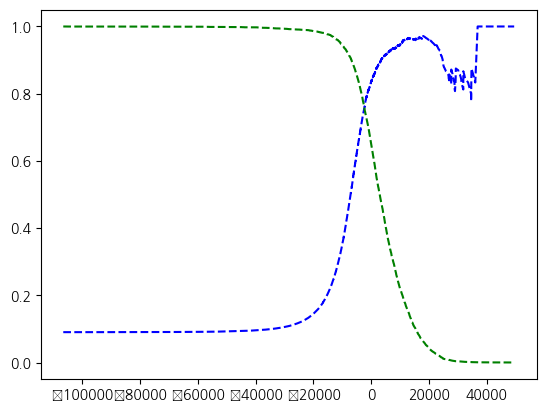

In [91]:
def plot_precision_recall_threshold(precisions,recalls,thresholds):
    plt.plot(thresholds,precisions[:-1],'b--',label='정밀도')
    plt.plot(thresholds,recalls[:-1],'g--',label='재현율')

plot_precision_recall_threshold(precisions,recalls, thresholds)
plt.show()

In [92]:
# 정밀도 90% 달성하는 것이 목표라고 했을 때 그래프에서 임곗값이 약 8000 정도임
# 최소한 정밀도 90%가 되는 가장 낮은 임곗값 찾기
threshold_90=thresholds[np.argmax(precisions>=0.9)]
threshold_90

3370.0194991439557

In [93]:
y_train_pred_90=(y_scores>=threshold_90)
y_train_pred_90

array([False, False, False, ...,  True, False, False])

In [94]:
precision_score(y_train_5,y_train_pred_90)

0.9000345901072293

In [95]:
recall_score(y_train_5,y_train_pred_90)

0.4799852425751706

## 3.3.5 ROC 곡선

In [96]:
from sklearn.metrics import roc_curve
fpr,tpr,thresholds=roc_curve(y_train_5,y_scores)

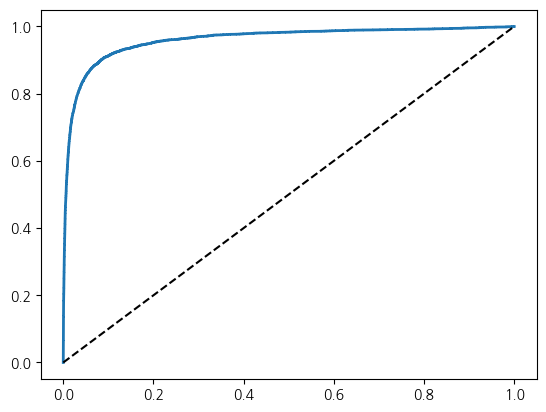

In [97]:
def plot_roc_curve(fpr,tpr,label=None):
    plt.plot(fpr,tpr,linewidth=2,label=label)
    plt.plot([0,1],[0,1],'k--') # 대각 점선
    
plot_roc_curve(fpr,tpr)
plt.show()

In [98]:
# 좋은 분류기는 점선에서 최대한 멀리 떨어져 있어야함 (왼쪽 위 모서리)
from sklearn.metrics import roc_auc_score
roc_auc_score(y_train_5,y_scores)

0.9604938554008616

In [100]:
from sklearn.ensemble import RandomForestClassifier
forest_clf=RandomForestClassifier(random_state=42)
y_probas_forest=cross_val_predict(forest_clf,X_train,y_train_5,cv=3,method='predict_proba')

In [106]:
y_scores_forest=y_probas_forest[:,1]
fpr_forest,tpr_forest,thresholds_forest=roc_curve(y_train_5,y_scores_forest)

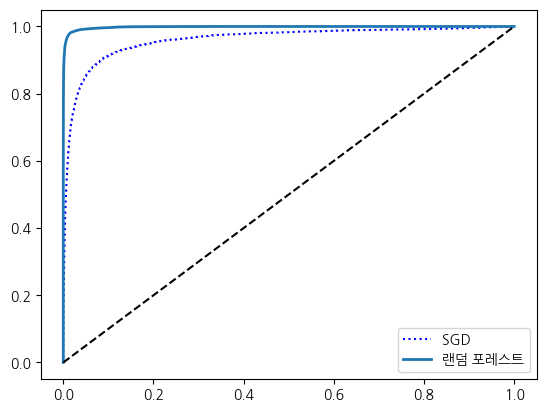

In [107]:
plt.plot(fpr,tpr,'b:',label='SGD')
plot_roc_curve(fpr_forest,tpr_forest,'랜덤 포레스트')
plt.legend(loc='lower right')
plt.show()

In [108]:
roc_auc_score(y_train_5,y_scores_forest)

0.9983436731328145

## 3.4 다중분류

In [111]:
X_train,X_test,y_train,y_test=X[:60000],X[60000:],y[:60000],y[60000:]

In [112]:
from sklearn.svm import SVC
svm_clf=SVC()
svm_clf.fit(X_train,y_train)
svm_clf.predict([some_digit])
# 0부터 9까지의 원래 타깃 클래스를 사용해 SVC를 훈련시킴
# 10개의 이진분류기를 훈련시키고 각각의 결정 점수를 얻어 점수가 가장 높은 클래스를 선택
some_digit_scores=svm_clf.decision_function([some_digit])
some_digit_scores

array([[ 1.72501977,  2.72809088,  7.2510018 ,  8.3076379 , -0.31087254,
         9.3132482 ,  1.70975103,  2.76765202,  6.23049537,  4.84771048]])

In [113]:
np.argmax(some_digit_scores)

5

In [114]:
svm_clf.classes_

array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9], dtype=uint8)

In [115]:
svm_clf.classes_[5]

5

In [116]:
from sklearn.multiclass import OneVsRestClassifier
ovr_clf=OneVsRestClassifier(SVC())
ovr_clf.fit(X_train,y_train)
ovr_clf.predict([some_digit])

array([5], dtype=uint8)

In [117]:
sgd_clf.fit(X_train,y_train)
sgd_clf.predict([some_digit])

array([3], dtype=uint8)

In [118]:
sgd_clf.decision_function([some_digit])

array([[-31893.03095419, -34419.69069632,  -9530.63950739,
          1823.73154031, -22320.14822878,  -1385.80478895,
        -26188.91070951, -16147.51323997,  -4604.35491274,
        -12050.767298  ]])

In [119]:
cross_val_score(sgd_clf,X_train,y_train,cv=3,scoring='accuracy')

array([0.87365, 0.85835, 0.8689 ])

In [120]:
from sklearn.preprocessing import StandardScaler
scaler=StandardScaler()
X_train_scaled=scaler.fit_transform(X_train.astype(np.float64))
cross_val_score(sgd_clf,X_train_scaled,y_train,cv=3,scoring='accuracy')

array([0.8983, 0.891 , 0.9018])

## 3.5 에러분석
 모델을 하나 찾았다는 가정하고 모델의 성능을 향상시킬 방법 찾기

In [121]:
y_train_pred=cross_val_predict(sgd_clf,X_train_scaled,y_train,cv=3)
conf_mx=confusion_matrix(y_train,y_train_pred)
conf_mx

array([[5577,    0,   22,    5,    8,   43,   36,    6,  225,    1],
       [   0, 6400,   37,   24,    4,   44,    4,    7,  212,   10],
       [  27,   27, 5220,   92,   73,   27,   67,   36,  378,   11],
       [  22,   17,  117, 5227,    2,  203,   27,   40,  403,   73],
       [  12,   14,   41,    9, 5182,   12,   34,   27,  347,  164],
       [  27,   15,   30,  168,   53, 4444,   75,   14,  535,   60],
       [  30,   15,   42,    3,   44,   97, 5552,    3,  131,    1],
       [  21,   10,   51,   30,   49,   12,    3, 5684,  195,  210],
       [  17,   63,   48,   86,    3,  126,   25,   10, 5429,   44],
       [  25,   18,   30,   64,  118,   36,    1,  179,  371, 5107]],
      dtype=int64)

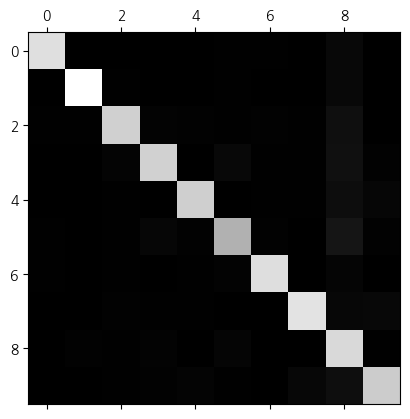

In [122]:
plt.matshow(conf_mx,cmap=plt.cm.gray)
plt.show()
# 숫자 5가 다른 숫자보다 어두워보임 
# meaning 5를 다른 숫자만큼 잘 분류하지 못했다는 뜻이거나
# 혹은 숫자 5의 이미지가 적다는 것
# 두경우에 대해 모두 확인해봐야함 

In [123]:
# 그래프의 에러 부분. 각값의 에러 비율을 비교
row_sums=conf_mx.sum(axis=1,keepdims=True)
norm_conf_mx=conf_mx/row_sums

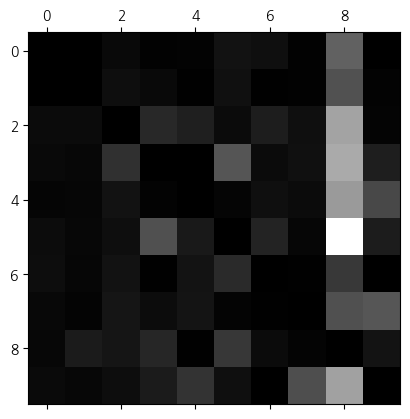

In [124]:
np.fill_diagonal(norm_conf_mx,0)
plt.matshow(norm_conf_mx,cmap=plt.cm.gray)
plt.show()
# class 8의 행이 상당히 밝음 meaning 많은 이미지 8로 잘못 분류되었음

In [132]:
# plot_digits 함수 생성
import matplotlib
def plot_digits(instances, images_per_row=10, **options):
    size = 28
    images_per_row = min(len(instances), images_per_row)
    images = [instance.reshape(size,size) for instance in instances]
    n_rows = (len(instances) - 1) // images_per_row + 1
    row_images = []
    n_empty = n_rows * images_per_row - len(instances)
    images.append(np.zeros((size, size * n_empty)))
    for row in range(n_rows):
        rimages = images[row * images_per_row : (row + 1) * images_per_row]
        row_images.append(np.concatenate(rimages, axis=1))
    image = np.concatenate(row_images, axis=0)
    plt.imshow(image, cmap = matplotlib.cm.binary, **options)
    plt.axis("off")

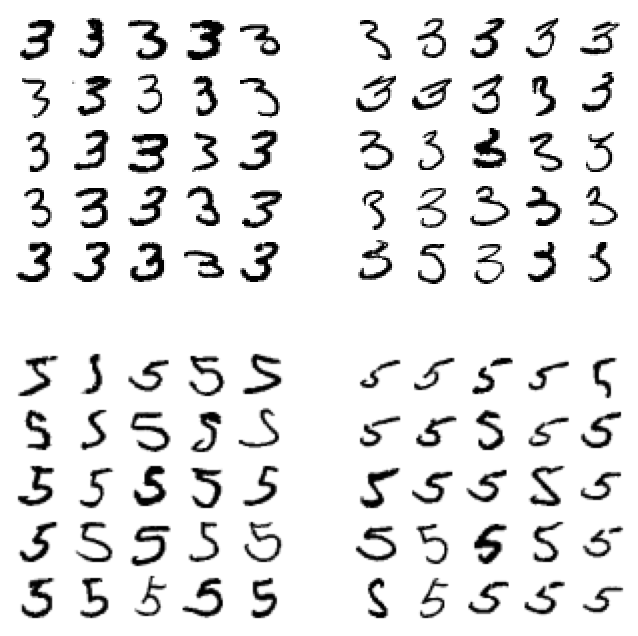

In [133]:
cl_a,cl_b=3,5
X_aa=X_train[(y_train==cl_a)&(y_train_pred==cl_a)]
X_ab=X_train[(y_train==cl_a)&(y_train_pred==cl_b)]
X_ba=X_train[(y_train==cl_b)&(y_train_pred==cl_a)]
X_bb=X_train[(y_train==cl_b)&(y_train_pred==cl_b)]
plt.figure(figsize=(8,8))
plt.subplot(221);plot_digits(X_aa[:25],images_per_row=5)
plt.subplot(222);plot_digits(X_ab[:25],images_per_row=5)
plt.subplot(223);plot_digits(X_ba[:25],images_per_row=5)
plt.subplot(224);plot_digits(X_bb[:25],images_per_row=5)
plt.show()
# 선형모델 SGDClassifier를 사용했기 때문에 새로운 이미지에 대해 단순히
# 픽셀 강도의 가중치의 합을 클래스의 점수로 계산함 -> 3,5의 경우 모델이 쉽게 혼동됨
# 분류기는 이미지의 위치나 회전 방향에 매우 민감하기 때문에 
# 이미지를 중앙에 위치시키고 회전되어 있지 않도록 전처리 하는 것이 중요

## 3.6 다중 레이블 분류
* 분류기가 샘플마다 여러개의 클래스를 출력해야 될 때
* 여러개의 이진 꼬리표를 출력하는 분류 시스템

In [127]:
from sklearn.neighbors import KNeighborsClassifier
y_train_large=(y_train>=7)
y_train_odd=(y_train%2==1)
y_multilabel=np.c_[y_train_large,y_train_odd]
knn_clf=KNeighborsClassifier()
knn_clf.fit(X_train,y_multilabel)

KNeighborsClassifier()

In [128]:
knn_clf.predict([some_digit])

C:\Users\MYCOM\anaconda3\lib\site-packages\sklearn\neighbors\_classification.py:228: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims` to True or False to avoid this warning.
  mode, _ = stats.mode(_y[neigh_ind, k], axis=1)


array([[False,  True]])

In [134]:
y_train_knn_pred=cross_val_predict(knn_clf,X_train, y_multilabel,cv=3)
f1_score(y_multilabel,y_train_knn_pred,average='macro')

C:\Users\MYCOM\anaconda3\lib\site-packages\sklearn\neighbors\_classification.py:228: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims` to True or False to avoid this warning.
  mode, _ = stats.mode(_y[neigh_ind, k], axis=1)
C:\Users\MYCOM\anaconda3\lib\site-packages\sklearn\neighbors\_classification.py:228: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdim

0.976410265560605

## 3.7 다중 출력 분류

다중 레이블 분류에서 한 레이블이 다중 클래스가 될 수 있도록 일반화한 것 

In [135]:
# 이미자를 위해 잡음을 제거하는 시스템 만들기
noise=np.random.randint(0,100,(len(X_train),784))
# 잡음 추가
X_train_mod=X_train+noise
noise=np.random.randint(0,100,(len(X_test),784))
# 잡음 추가
X_test_mod=X_test+noise
y_train_mod=X_train
y_test_mod=X_test

C:\Users\MYCOM\anaconda3\lib\site-packages\sklearn\neighbors\_classification.py:228: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims` to True or False to avoid this warning.
  mode, _ = stats.mode(_y[neigh_ind, k], axis=1)


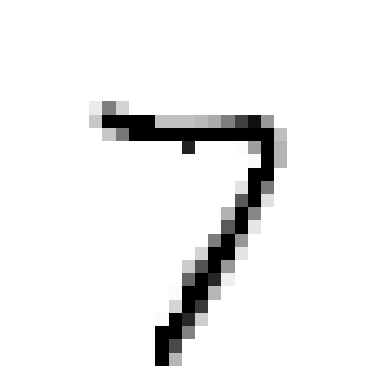

In [143]:
knn_clf = KNeighborsClassifier()
knn_clf.fit(X_train_mod, y_train_mod)
clean_digit = knn_clf.predict([X_test_mod[0]])
plot_digits(clean_digit)
#save_fig("cleaned_digit_example_plot")  # 추가 코드 – 그림 3–13을 저장합니다
plt.show()